In [2]:
from google.colab import files
from google.colab import drive
import os


drive.mount('/content/drive')

uploaded_files = files.upload()

drive_folder = '/content/drive/My Drive/Stock-Price-Prediction'

os.makedirs(drive_folder, exist_ok=True)

for file_name in uploaded_files.keys():
    local_file_path = os.path.join(drive_folder, file_name)
    with open(local_file_path, "wb") as f:
        f.write(uploaded_files[file_name])
    print(f"Uploaded {file_name} to {drive_folder}")



Mounted at /content/drive


In [3]:

import os
os.chdir('/content/drive/My Drive/Stock-Price-Prediction')
print(os.listdir())

['AAPL.csv', 'AMZN.csv', 'GOOGL.csv', 'META.csv', 'MSFT.csv', 'NFLX.csv', 'NVDA.csv', 'TSLA.csv']


In [4]:
import pandas as pd
ticker_symbols = [
    "AAPL", "MSFT", "NVDA", "NFLX", "GOOGL",
    "AMZN", "TSLA", "META"
]
for ticker in ticker_symbols:
    try:
        globals()[f"{ticker}_df"] = pd.read_csv(f"{ticker}.csv")
        print(f"Data for {ticker} loaded successfully.")
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")


Data for AAPL loaded successfully.
Data for MSFT loaded successfully.
Data for NVDA loaded successfully.
Data for NFLX loaded successfully.
Data for GOOGL loaded successfully.
Data for AMZN loaded successfully.
Data for TSLA loaded successfully.
Data for META loaded successfully.


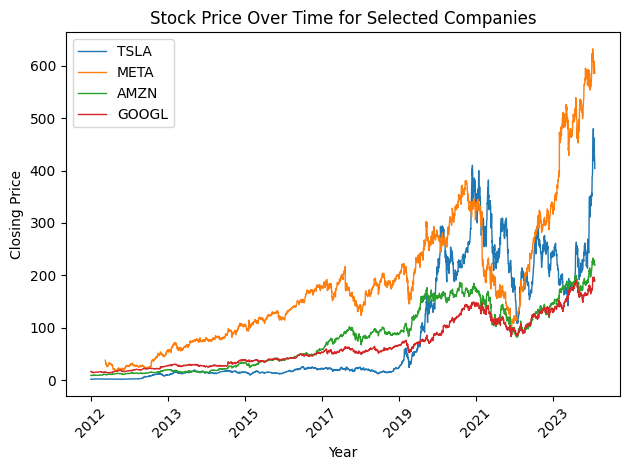

In [6]:
import random
import matplotlib.pyplot as plt

selected_tickers = random.sample(ticker_symbols, 4)

for ticker in selected_tickers:
    df = globals()[f"{ticker}_df"]
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    plt.plot(df['Date'], df['Close'], label=ticker, linewidth=1)

xticks = df['Date'].dt.strftime('%Y')[::500]
plt.xticks(df['Date'][::500], xticks, rotation=45)

plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('Stock Price Over Time for Selected Companies')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
for ticker in ticker_symbols:
    df = globals()[f"{ticker}_df"]
    print(f"Columns for {ticker}: {df.columns}")

Columns for AAPL: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')
Columns for MSFT: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')
Columns for NVDA: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')
Columns for NFLX: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')
Columns for GOOGL: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')
Columns for AMZN: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')
Columns for TSLA: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')
Columns for META: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Date'], dtype='object')


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, SimpleRNN, Input
from keras import regularizers
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [9]:
class stock_prediction_cls:

    def __init__(self, comp_df):
        data = comp_df.filter(['Open'])
        dataset = data.values
        training_data_len = int(np.ceil(len(dataset) * 0.80))
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = self.scaler.fit_transform(dataset)
        train_data = scaled_data[0:int(training_data_len), :]
        self.X_train = []
        self.y_train = []
        for i in range(60, len(train_data)):
            self.X_train.append(train_data[i-60:i, 0])
            self.y_train.append(train_data[i, 0])
        self.X_train, self.y_train = np.array(self.X_train), np.array(self.y_train)
        test_data = scaled_data[training_data_len - 60:, :]
        self.X_test = []
        self.y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            self.X_test.append(test_data[i-60:i, 0])
        self.X_test = np.array(self.X_test)
        test_dates = comp_df['Date'].values
        self.testd = test_dates[training_data_len:]
        self.model_score = []

    def LSTM_model(self):
        Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
        Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1))
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(Xtrain.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(32))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(Xtrain, self.y_train, batch_size=1, epochs=10)
        predictions = model.predict(Xtest)
        predictions = self.scaler.inverse_transform(predictions)
        score = metrics.r2_score(self.y_test, predictions)
        self.model_score.append(["LSTM", score])
        print(f"LSTM Model R² Score: {score}")

        plt.plot(predictions)
        plt.plot(self.y_test)
        step_size = 50
        tick_positions = range(0, len(self.y_test), step_size)
        tick_labels = self.testd[tick_positions]
        plt.xticks(tick_positions, tick_labels, rotation=45)
        plt.legend(["Predicted", "Observed"])
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Price', fontsize=18)
        plt.title("LSTM")
        plt.tight_layout()
        plt.show()

    def basic_ann_model(self):
        classifier = Sequential()
        classifier.add(Dense(units=128, activation='relu', input_dim=self.X_train.shape[1]))
        classifier.add(Dropout(0.2))
        classifier.add(Dense(units=64))
        classifier.add(Dropout(0.2))
        classifier.add(Dense(units=1))
        classifier.compile(optimizer='adam', loss='mean_squared_error')
        classifier.fit(self.X_train, self.y_train, batch_size=32, epochs=10)
        predictions = classifier.predict(self.X_test)
        predictions = self.scaler.inverse_transform(predictions)
        score = metrics.r2_score(self.y_test, predictions)
        self.model_score.append(["ANN", score])
        print(f"ANN Model R² Score: {score}")

        plt.plot(predictions)
        plt.plot(self.y_test)
        step_size = 50
        tick_positions = range(0, len(self.y_test), step_size)
        tick_labels = self.testd[tick_positions]
        plt.xticks(tick_positions, tick_labels, rotation=45)
        plt.legend(["Predicted", "Observed"])
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Price', fontsize=18)
        plt.title("ANN")
        plt.tight_layout()
        plt.show()

    def autoen_model(self):
      encoding_dim = 32
      input_dim = self.X_train.shape[1]
      input_layer = Input(shape=(input_dim,))
      encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(1e-5))(input_layer)
      encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
      decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
      decoder = Dense(1, activation='relu')(decoder)
      autoencoder = Model(inputs=input_layer, outputs=decoder)
      autoencoder.compile(optimizer='adam', loss='mean_squared_error')
      autoencoder.fit(self.X_train, self.y_train, epochs=10, batch_size=32, shuffle=True)
      predictions = autoencoder.predict(self.X_test)
      predictions = self.scaler.inverse_transform(predictions)
      score = metrics.r2_score(self.y_test, predictions)
      self.model_score.append(["Auto Encoder", score])
      print(f"Auto Encoder Model R² Score: {score}")

      plt.plot(predictions)
      plt.plot(self.y_test)
      step_size = 50
      tick_positions = range(0, len(self.y_test), step_size)
      tick_labels = self.testd[tick_positions]
      plt.xticks(tick_positions, tick_labels, rotation=45)
      plt.legend(["Predicted", "Observed"])
      plt.xlabel('Date', fontsize=18)
      plt.ylabel('Price', fontsize=18)
      plt.title("Auto Encoder")
      plt.tight_layout()
      plt.show()


    def Mlp_model(self):
      regr = MLPRegressor(hidden_layer_sizes=100, alpha=0.01, solver='lbfgs', shuffle=True)
      regr.fit(self.X_train, self.y_train)
      predictions = regr.predict(self.X_test)
      predictions = predictions.reshape(-1, 1)
      predictions = self.scaler.inverse_transform(predictions)
      score = metrics.r2_score(self.y_test, predictions)
      self.model_score.append(["MLP", score])
      print(f"MLP Model R² Score: {score}")

      plt.plot(predictions)
      plt.plot(self.y_test)
      step_size = 50
      tick_positions = range(0, len(self.y_test), step_size)
      tick_labels = self.testd[tick_positions]
      plt.xticks(tick_positions, tick_labels, rotation=45)
      plt.legend(["Predicted", "Observed"])
      plt.xlabel('Date', fontsize=18)
      plt.ylabel('Price', fontsize=18)
      plt.title("MLP")
      plt.tight_layout()
      plt.show()


    def rnn_model(self):
      Xtrain = np.reshape(self.X_train, (self.X_train.shape[0], self.X_train.shape[1], 1))
      Xtest = np.reshape(self.X_test, (self.X_test.shape[0], self.X_test.shape[1], 1))
      model = Sequential()
      model.add(SimpleRNN(units=4, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
      model.add(Dense(1))
      model.compile(loss='mean_squared_error', optimizer='adam')
      model.fit(Xtrain, self.y_train, epochs=10, batch_size=1)
      predictions = model.predict(self.X_test)
      predictions = self.scaler.inverse_transform(predictions)
      score = metrics.r2_score(self.y_test, predictions)
      self.model_score.append(["ANN", score])
      print(f"ANN Model R² Score: {score}")

      plt.plot(predictions)
      plt.plot(self.y_test)
      step_size = 50
      tick_positions = range(0, len(self.y_test), step_size)
      tick_labels = self.testd[tick_positions]
      plt.xticks(tick_positions, tick_labels, rotation=45)
      plt.legend(["Predicted", "Observed"])
      plt.xlabel('Date', fontsize=18)
      plt.ylabel('Price', fontsize=18)
      plt.title("simple RNN")
      plt.tight_layout()
      plt.show()



    def best_model(self):
        Dict = {item[0]: item[1:][0] for item in self.model_score}
        keys = list(Dict.keys())
        vals = list(Dict.values())

        print("\nModel Scores:")
        for model, score in Dict.items():
            print(f"{model}: R² Score = {score}")

        best_model_index = vals.index(max(vals))
        print(f"\nThe best model is {keys[best_model_index]}")
        print(f"R² score of {keys[best_model_index]} is {max(vals)}")


In [10]:
GOOGL_df.head()

,Open,High,Low,Close,Volume,Date
0,16.280821,16.660076,16.266609,16.591755,146912940,2012-01-03 00:00:00+00:00
1,16.582279,16.712440,16.472319,16.663319,114445440,2012-01-04 00:00:00+00:00
2,16.509970,16.555849,16.362855,16.432173,131184684,2012-01-05 00:00:00+00:00
3,16.435664,16.456860,16.202276,16.208012,107608284,2012-01-06 00:00:00+00:00
4,16.120241,16.132708,15.490142,15.520812,232671096,2012-01-09 00:00:00+00:00


In [11]:
google_stock=stock_prediction_cls(GOOGL_df)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2556/2556 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 0.0038
Epoch 2/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0021
Epoch 3/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0018
Epoch 4/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0014
Epoch 5/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0013
Epoch 6/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0013
Epoch 7/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0011
Epoch 8/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 9.8282e-04
Epoch 9/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0013
Epoch 10/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0011
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM Model R² Score: 0.9840980525703817


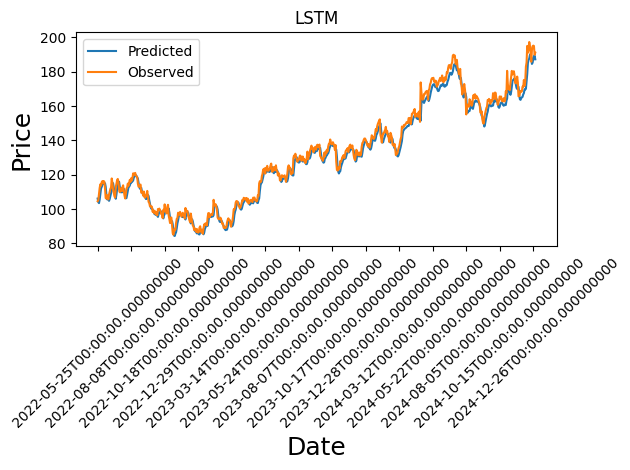

In [18]:
stock_prediction_cls.LSTM_model(google_stock)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0504
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
ANN Model R² Score: 0.9351333391526827


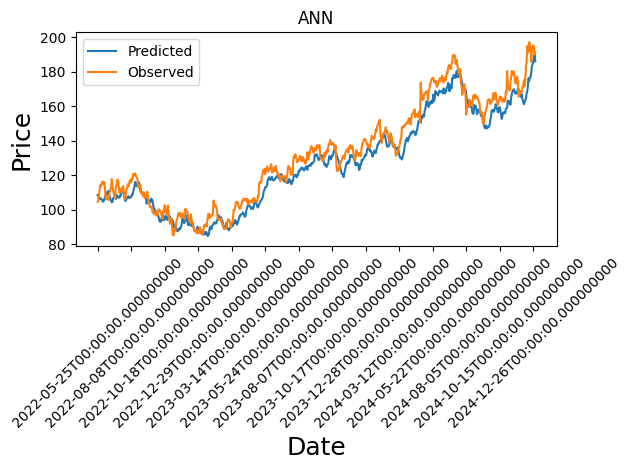

In [13]:
stock_prediction_cls.basic_ann_model(google_stock)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0299
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0265e-04
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8062e-04
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4332e-04
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1003e-04
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9339e-04
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3214e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Auto Encoder Model R² Score: 0.9366746426484237


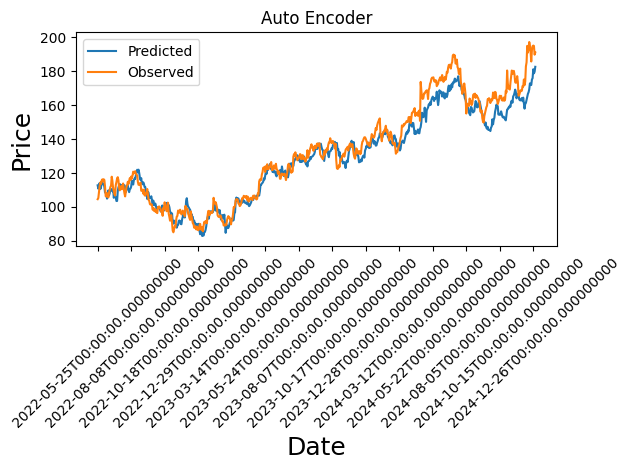

In [14]:
stock_prediction_cls.autoen_model(google_stock)

MLP Model R² Score: 0.9767860651687859


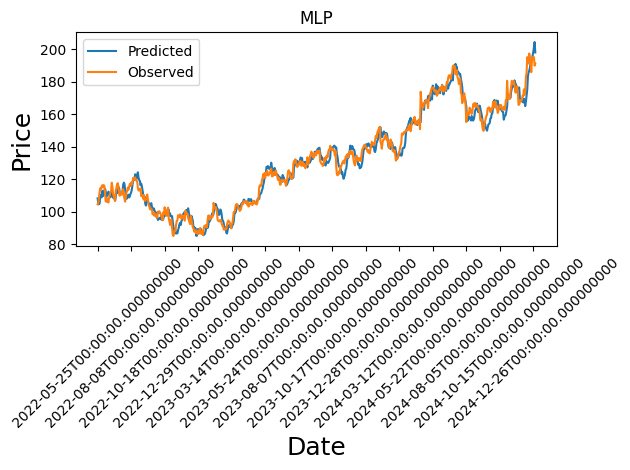

In [15]:
stock_prediction_cls.Mlp_model(google_stock)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2556/2556 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0233
Epoch 2/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 3.9106e-04
Epoch 3/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.2437e-04
Epoch 4/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.4629e-04
Epoch 5/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.2706e-04
Epoch 6/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.2798e-04
Epoch 7/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.1349e-04
Epoch 8/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 8.8120e-05
Epoch 9/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.4819e-05
Epoch 10/10
2556/2556 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 7.9833e-05
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
ANN Model R² Score: 0.9831940211862912


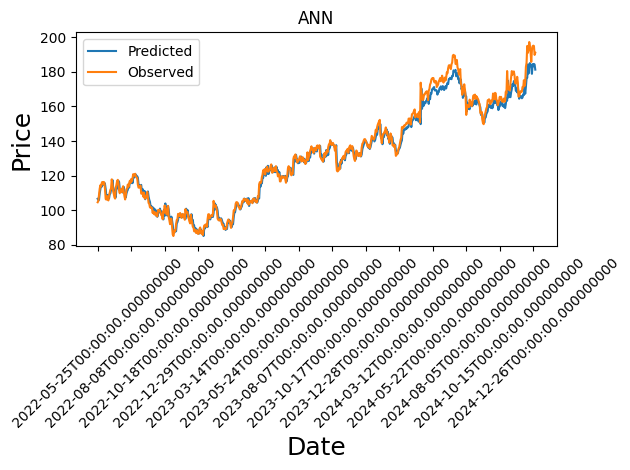

In [16]:
stock_prediction_cls.rnn_model(google_stock)

In [19]:
stock_prediction_cls.best_model(google_stock)


Model Scores:
LSTM: R² Score = 0.9840980525703817
ANN: R² Score = 0.9831940211862912
Auto Encoder: R² Score = 0.9366746426484237
MLP: R² Score = 0.9767860651687859

The best model is LSTM
R² score of LSTM is 0.9840980525703817
